## Getting started with `relign`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from relign.generator import (
    LensEnv,
    GymnasiumEnv,
)

### Setup up the environment

Here, we can configure how many lenses we want to adjust and how strong the noise should be  -within the objective as well as in the station

In [2]:
env = GymnasiumEnv(
    env_cls=LensEnv,
    n_lenses=3,
    noise_angle=0.0,
    noise_translation=0.0,
    seed=10
)

Create a new situation by "resetting" the environment:

In [3]:
obs, _ = env.reset()

### Visualize the scene and the sensor output

2025-03-13 11:23:13 WARN main [BitmapTextureImpl] BitmapTexture: texture named "" contains pixels that exceed the [0, 1] range!

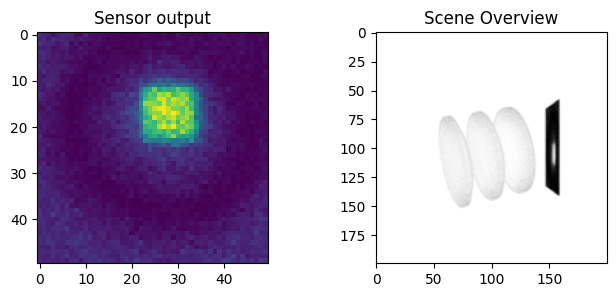

In [4]:
overviews = env.env.render_scene_overview()
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Display the initial observation
ax[0].imshow(obs[0])
ax[0].set_title('Sensor output')

# Display the rendered scene overview
ax[1].imshow(overviews, cmap='gray')
ax[1].set_title('Scene Overview')

plt.show()

The objective is highly mis-alignment, lets try to fix that by rotating to a new position

In [5]:
action = np.array([0.1, -0.05, 0.1, -0.1, 0.2])

By calling `env.step`, we can make the env move:

In [6]:
obs, reward, done, info, _ = env.step(action)

2025-03-13 11:23:15 WARN main [BitmapTextureImpl] BitmapTexture: texture named "" contains pixels that exceed the [0, 1] range!

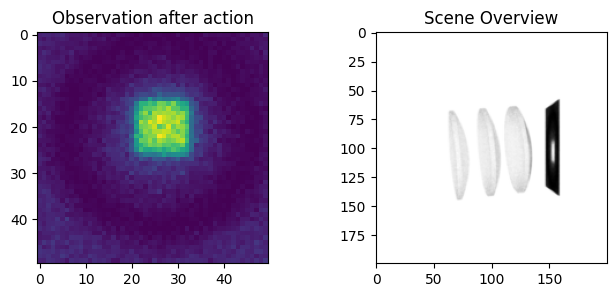

In [7]:
overviews = env.env.render_scene_overview()
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].imshow(obs[0])
ax[0].set_title('Observation after action')
ax[1].imshow(overviews, cmap='gray')
ax[1].set_title('Scene Overview')

plt.show()

2025-03-13 11:23:18 WARN main [BitmapTextureImpl] BitmapTexture: texture named "" contains pixels that exceed the [0, 1] range!

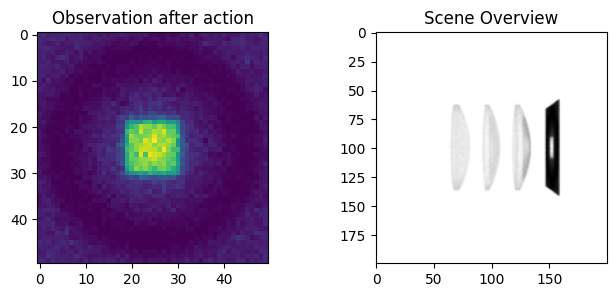

In [8]:
# Perform a valid action for LensEnv, such as taking a  action to the center of the scene
pos = 0.5 * np.ones(5)
action  = env.env._compute_move_to_position(pos)
obs, reward, done, info, _ = env.step(action)
overviews = env.env.render_scene_overview()
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].imshow(obs[0])
ax[0].set_title('Observation after action')
ax[1].imshow(overviews, cmap='gray')
ax[1].set_title('Scene Overview')

plt.show()

### Two lenses

Same can be done with an objective consisting of two lenses only. Now, we use more noise inside the lens system:

In [9]:
env = GymnasiumEnv(
    env_cls=LensEnv,
    n_lenses=2,
    noise_angle=0.5,
    noise_translation=0.75,
    seed=10,
)

obs, _ = env.reset()

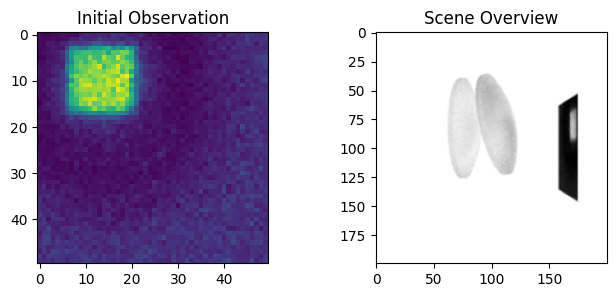

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Display the initial observation
ax[0].imshow(obs[0])
ax[0].set_title('Initial Observation')

overviews = env.env.render_scene_overview(sensor_distance=4)
# Display the rendered scene overview
ax[1].imshow(overviews, cmap='gray')
ax[1].set_title('Scene Overview')

plt.show()

Here, there is much more noise within the objective we cannot adjust in the alignment.

The "optimum" place without any noise is always at the absolute position $(0.5, 0.5, 0.5, 0.5, 0.5)$ (but in each situation with another relative offset). The position can be explored like this:

In [11]:
pos = 0.5 * np.ones(5)
action  = env.env._compute_move_to_position(pos)
obs, reward, done, info, _ = env.step(action)

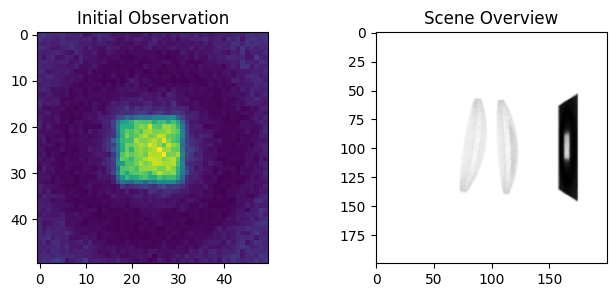

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Display the initial observation
ax[0].imshow(obs[0])
ax[0].set_title('Initial Observation')

overviews = env.env.render_scene_overview(sensor_distance=4)
# Display the rendered scene overview
ax[1].imshow(overviews, cmap='gray')
ax[1].set_title('Scene Overview')

plt.show()

This would be the optimal position if there was no lens noise.
In fact, as we do not know the exact individual lens noise, we do not know the real optimum.

## Reinforcement learning
Here is a quick example how a RL model can be trained on our environment:

In [13]:
from stable_baselines3 import PPO
from relign.network import CustomCNN

In [14]:
model = PPO(
    env=env,
    policy="CnnPolicy",
    policy_kwargs=dict(
        features_extractor_class=CustomCNN,
        features_extractor_kwargs=dict(features_dim=256),
        log_std_init=-2.5,
    ),
)